# Model-Based Decision Making

This notebook contains the final code of Group 30's assignment for the course EPA1361.

In this code, we explore scenarios for the studied policy problem (flood risk management for the IJssel river) using open exploration, and then apply directed search (MORDM) to find optimal results.

## Table of contents
1) [Set Up](#Set-up)
2) [Problem formulation 2](#Problem-formulation-2)
3) [Exploration](#Exploration)
4) [Optimization](#Optimization)
    - [Convergence](#Convergence)
    - [Constraints and solutions](#Constrain-solutions)
    - [Uncertainty](#Uncertainty)
    - [Scenario discovery using PRIM](#Scenario-Discovery)
    - [Robustness, signal to noise](#Robustness)
5) [Maximum Regret](#Maximum-regret) 

# Set up

In [1]:
# Settings
save_exploration_data = False
save_figures = True
save_hv_data = False
save_result_data = True

In [42]:
# All needed imports
## Standard packages
!pip install ema_workbench
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from datetime import datetime
import json
import copy
from copy import deepcopy
from pathlib import Path
import collections

In [3]:
## initiating EMA workbench
from ema_workbench import (
    Policy,
    Scenario,
    HypervolumeMetric,
    ScalarOutcome,
    ema_logging,
    save_results,
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,)

#EMA workbench - optimization
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)

#EMA workbench - analysis
from ema_workbench.analysis import (
    parcoords,
    prim,
    dimensional_stacking,
    feature_scoring,
    scenario_discovery_util
)
## IJssel dike model
from dike_model_function import DikeNetwork  
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

import math

C:\Users\lykao\New folder\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [4]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher

!pip install xlrd>=2.0.1


import pandas as pd
import networkx as nx

print(pd.__version__)
print(nx.__version__)

2.2.2
3.2.1


In [5]:
# Set up
## Set up logging
ema_logging.log_to_stderr(ema_logging.INFO)
## Set up folders
##if save_exploration_data:
  ##  exploration_data_path = "./MBDM_Final_Data/Exploration_Data"
   ## Path(exploration_data_path).mkdir(parents=True, exist_ok=True)
##if save_result_data:
  ##  results_path = "./MBDM_Final_Data/Results"
   ## Path(results_path).mkdir(parents=True, exist_ok=True)
#if save_figures:
 #   figures_path = "./MBDM_Final_Data/Figures"
  #  Path(figures_path).mkdir(parents=True, exist_ok=True)

<Logger EMA (DEBUG)>

# Problem formulation 2

In [6]:
# Selecting problem formulation number 2
    # each problem formulation has its own list of outcomes and 2 suits Delta best 
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [7]:
#enlisting uncertainties, their types, lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [8]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [9]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x00000295C1CEB240>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x00000295C1CEB240>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x00000295C1CEB240>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x00000295C1CEB240>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [10]:
# Function to get default values for all levers
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

# Exploration

We will explore 3 policies:

1. A baseline (no actions taken)
2. Implementing room for the river (RfR) everywhere
3. The final policy of the MBDM debate, including RfR in dike rings 1 and 4, and moderate dike heightening in each dike ring

In [11]:
# defining specific policies
# policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations

# This function will return the policy list, based on the default values of a problem formulation.

def get_policies(do_nothing_dict):
    policies = []

    # Baseline policy: do nothing 
    policies.append(Policy("Baseline", **do_nothing_dict))

    # RfR everywhere policy
    rfr_everywhere = do_nothing_dict.copy()
    for dike_ring in range(5):  # 0 to 4
        for time_step in range(3):  # 0 to 2
            rfr_everywhere[f"{dike_ring}_RfR {time_step}"] = 1
    policies.append(Policy("RfR everywhere", **rfr_everywhere))

    #Policy preference from Delta (Rijkswaterstaat was also consulted)
    final_policy = do_nothing_dict.copy()
    final_policy.update({
        '0_RfR 0': 1,  # Dike Ring A2 - Cortenoever (Room for the River)
        '2_RfR 0': 1,  # Dike Ring A3 - Zutphen (Room for the River)
        'DaysToThreat': 3,  # Days to Threat
        'A.1_DikeIncrease 0': 0.5,  # A1 - Doesburg: 50 cm
        'A.4_DikeIncrease 0': 0.7,  # A4 - Gorssel: 70 cm
        'A.5_DikeIncrease 0': 0.8   # A5 - Deventer: 80 cm
    })
    policies.append(Policy("Final approved policy", **final_policy))

    return policies
""" REAL FINAL POLICY
 final_policy.update({
        '0_RfR 0': 1,  # Dike Ring A2 - Cortenoever (Room for the River)
        '2_RfR 0': 1,  # Dike Ring A3 - Zutphen (Room for the River)
        '3_RfR 0': 1,  # Dike Ring A5 - Deventer (Room for the River)
        'DaysToThreat': 3,  # Days to Threat
        'A.3_DikeIncrease 0': 0.5,  # A3 - Zutphen: 50 cm
        'A.4_DikeIncrease 0': 0.5,  # A4 - Gorssel: 50 cm
        'A.5_DikeIncrease 0': 0.5   # A5 - Deventer: 50 cm
    })
    policies.append(Policy("Final approved policy", **final_policy))

    return policies

"""

' REAL FINAL POLICY\n final_policy.update({\n        \'0_RfR 0\': 1,  # Dike Ring A2 - Cortenoever (Room for the River)\n        \'2_RfR 0\': 1,  # Dike Ring A3 - Zutphen (Room for the River)\n        \'3_RfR 0\': 1,  # Dike Ring A5 - Deventer (Room for the River)\n        \'DaysToThreat\': 3,  # Days to Threat\n        \'A.3_DikeIncrease 0\': 0.5,  # A3 - Zutphen: 50 cm\n        \'A.4_DikeIncrease 0\': 0.5,  # A4 - Gorssel: 50 cm\n        \'A.5_DikeIncrease 0\': 0.5   # A5 - Deventer: 50 cm\n    })\n    policies.append(Policy("Final approved policy", **final_policy))\n\n    return policies\n\n'

In [12]:
policies = get_policies(get_do_nothing_dict())

#Passes the policies list to EMA workbench experiment default Latin Hypercube Sampling
n_scenarios = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)



[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 200 scenarios * 3 policies * 1 model(s) = 600 experiments
100%|████████████████████████████████████████| 600/600 [02:07<00:00,  4.72it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
# Save exploration results
#if save_exploration_data:
 #   save_results(results, f"{exploration_data_path}/exploration_PF2_results.tar.gz")

In [14]:
# observing the simulation runs
# Separate results into experiments and outcomes, and select policies
experiments, outcomes = results
policies = experiments['policy']
print(outcomes.keys())

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


In [15]:
# Convert outcomes to DataFrame and merge with policy labels
data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

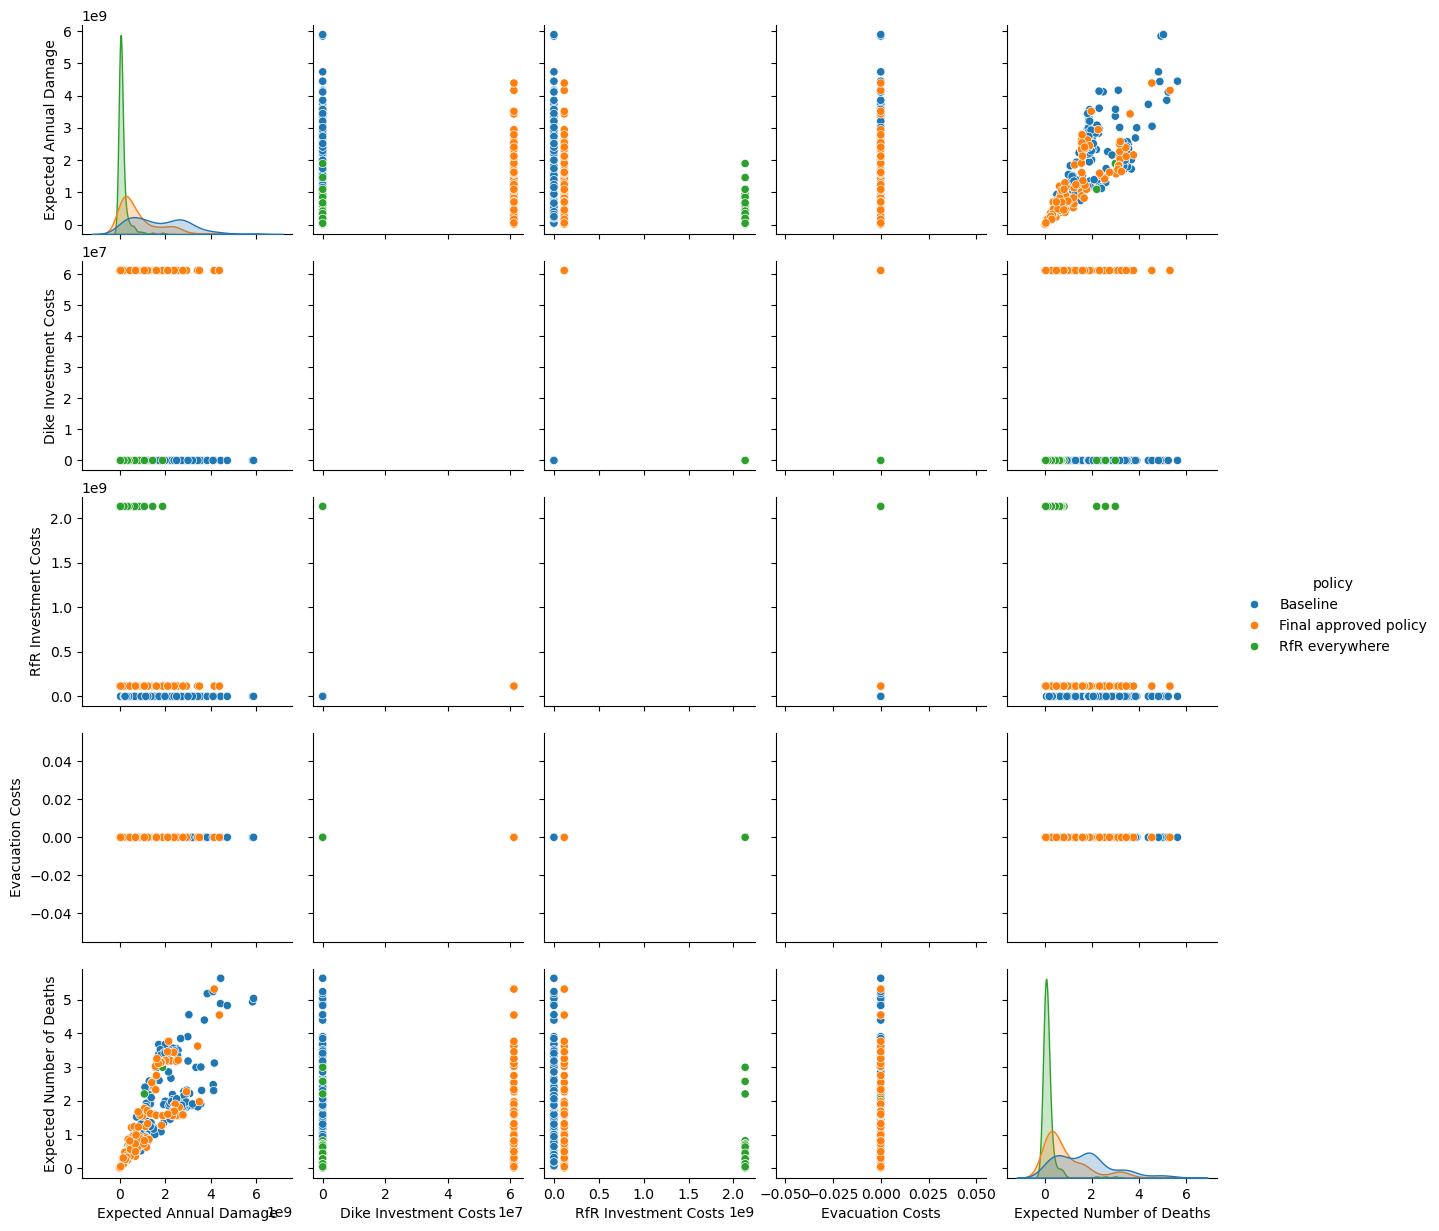

In [16]:
# Plot results
sns.pairplot(data, hue='policy', vars=outcomes.keys(), )
#if save_figures:
 #   plt.savefig(figures_path + "/PF2_open_expl_policies.png", dpi=300)
plt.show()

## Optimization

Each epsilon value corresponds to a model outcome: expected damages, dike investment costs, RfR costs, evacuation costs, and casualties. 

Reflecting the Delta Commission’s mandate, we assign lower epsilon values to dike investment costs and casualties, emphasizing system safety and equity. We assign moderate values to damages and evacuation costs to allow trade-offs, and higher values to RfR costs(supporting nature-based solutions)

In [17]:
# Optimisation settings (see final report for more detail)
epsilon = [0.2, 0.1, 0.3, 0.2, 0.01]
#NFE settings
nfe = 15000 ## 10000 or 15000?
    #higher NFEs take more time (depending on computer power), however a middleground needs to be found:
        #where the nfe is high enough and convergence can still be seen = 10,000 

## Reference Scenario
See report for more detail in why these values where chosen 

In [18]:
#Model specification
dike_model, planning_steps = get_model_for_problem_formulation(2)

reference_scenario = Scenario('reference', 
**{
    'discount rate 0': 1.5,
    'discount rate 1': 1.5,
    'discount rate 2': 1.5,
    'A.0_ID flood wave shape': 60, 
    'A.1_Bmax': 200, 
    'A.1_pfail': 0.15,
    'A.1_Brate': 7,
    'A.2_Bmax': 200, 
    'A.2_pfail': 0.15, 
    'A.2_Brate': 7,
    'A.3_Bmax': 200,
    'A.3_pfail': 0.15, 
    'A.3_Brate': 7,
    'A.4_Bmax': 200,
    'A.4_pfail': 0.15, 
    'A.4_Brate': 7,
    'A.5_Bmax': 200, 
    'A.5_pfail': 0.15,
    'A.5_Brate': 7
})

# === Optimization ===

# Set up data folder and remove "tmp" folder if left from previous runs
#optimization_data_path = "./MBDM_Final_Data/Optimization_Data"
#Path(optimization_data_path).mkdir(parents=True, exist_ok=True)
#tmppath = Path(optimization_data_path) / 'tmp'
#if tmppath.exists() and tmppath.is_dir():
 #   shutil.rmtree(tmppath)

## Convergence
Convergence is used to select robust policies. This approach will be using epsilon progress. 
(Hypervolume was considered, but it is computationally very expsensive, and e-progress can still provide a good sense of convergence without the computaiotn strain)

[MainProcess/INFO] pool started with 8 workers
16330it [50:47,  5.36it/s]                                                     
[MainProcess/INFO] optimization completed, found 548 solutions
[MainProcess/INFO] terminating pool


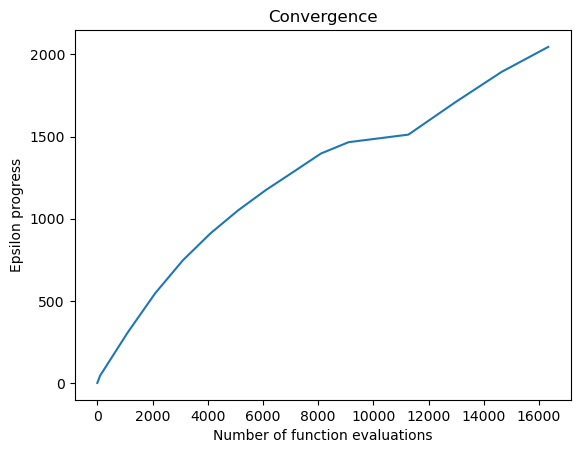

In [19]:
#set up convergence metrics with epsilon progress
convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    optimization_result, optimization_convergence = evaluator.optimize(
        nfe=nfe,
        searchover='levers',
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario
    )

# Plot convergence 
plt.figure()
plt.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
plt.xlabel('Number of function evaluations')
plt.ylabel('Epsilon progress')
plt.title('Convergence')
plt.show()

This reference scenario using the worst-case conditions of the 75th percentile. The epsilonmetric ensures that the optimization algorithm carefully balances trade-offs between the preferred objectives. 

The graph shows that the optimization algorithm is converging as expected. The beginning stages show rapid improvements, while later stages show diminishing returns.

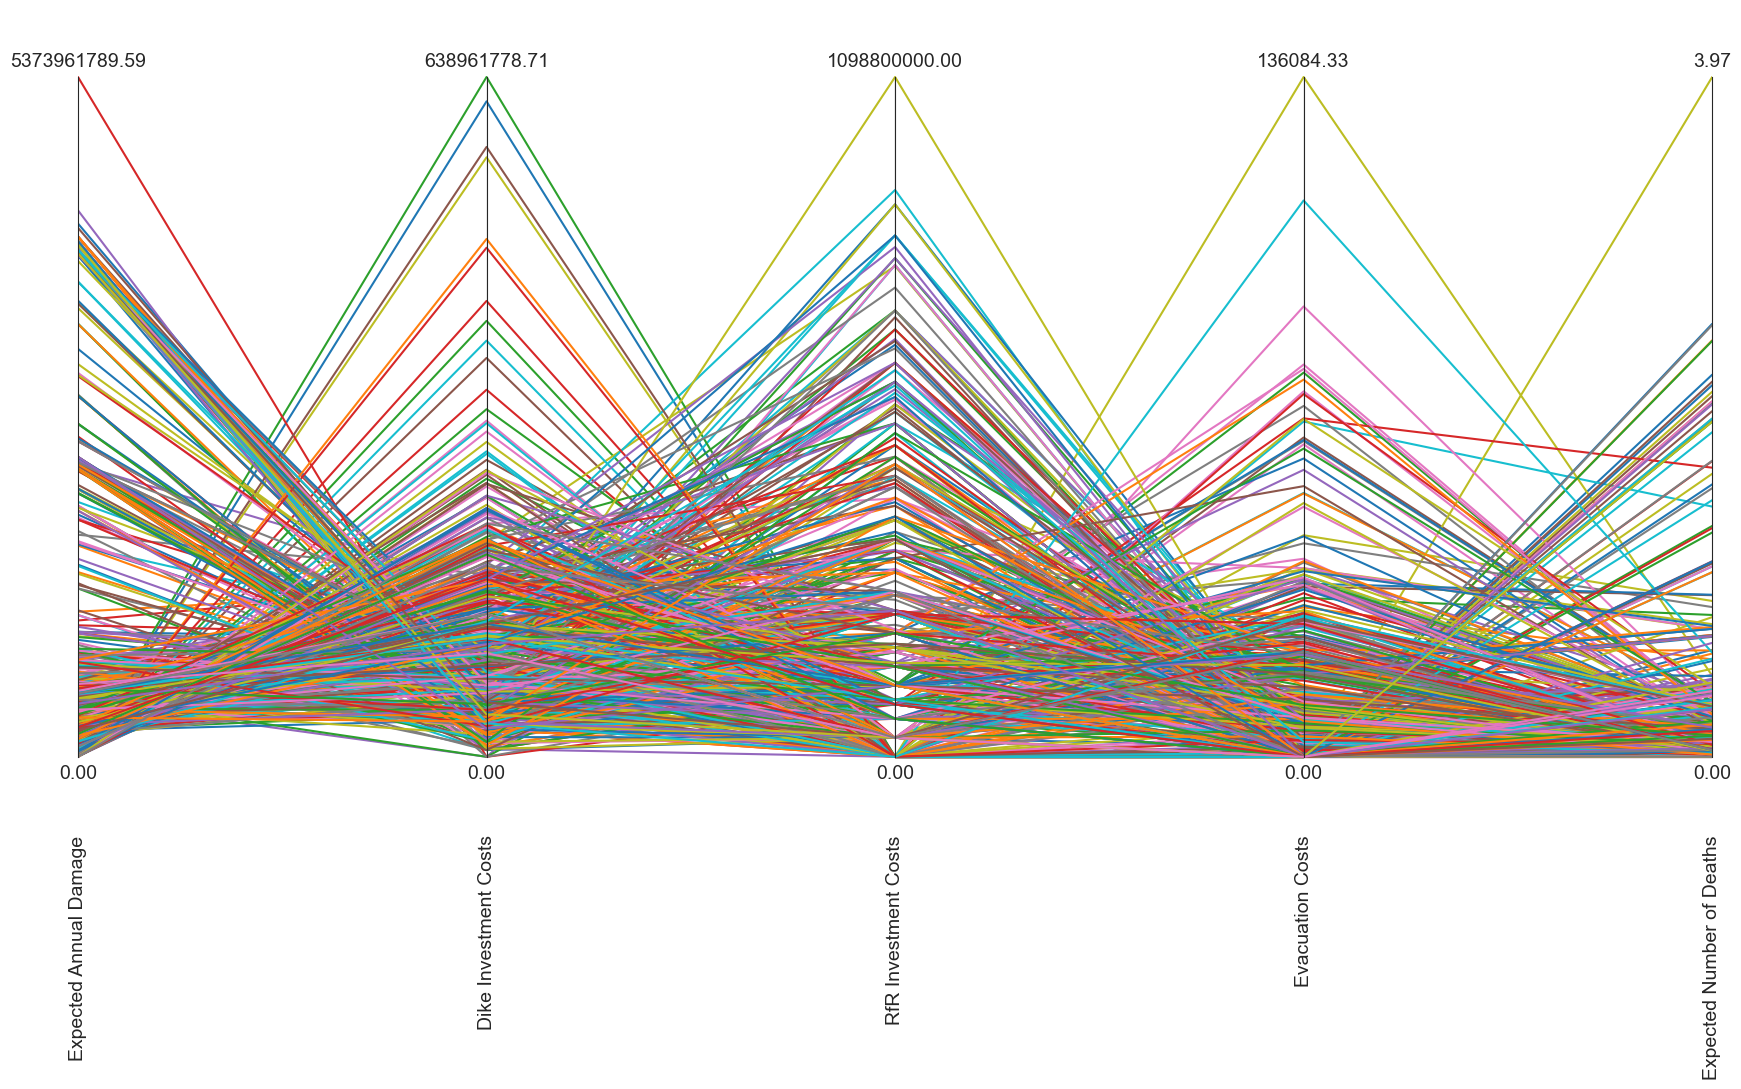

In [20]:
#getting the outcome names from dike model
outcome_names = [o.name for o in dike_model.outcomes] 

#converting optimization results to df
data = pd.DataFrame(optimization_result)
data = data.loc[:, outcome_names] #extract only columns

limits = parcoords.get_limits(data)

#!!!!!!!!!!!!!! MAybe change this later ---> Set lower limits for some objectives
limits.loc[0, ['Expected Annual Damage','Dike Investment Costs','RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()

## Constrain solutions


Two min constraining factors are considered:
1) Expected number of deaths
2) Filter by expected annual damage with a threshold of €10 million


In [21]:
#first constraint: filter by expected deaths to be very low, following Delta Mandate
constrained_optim_results = optimization_result[
    optimization_result['Expected Number of Deaths'] < 0.001]

# Second constraint: filter by expected annual damage (threshold €10 million)
#constrained_optim_results = constrained_optim_results[
 #   constrained_optim_results['Expected Annual Damage'] < 10000000]


# Second constraint: filter by dike investment cost (threshold €10 million)
constrained_optim_results = constrained_optim_results[
    constrained_optim_results['Dike Investment Costs'] < 450_000_000]


# Remove outcome columns to get the policy dataframe
optimization_policies = constrained_optim_results.drop([o.name for o in dike_model.outcomes], axis=1) # will create a df of constrainted policies 
#optimization_policies

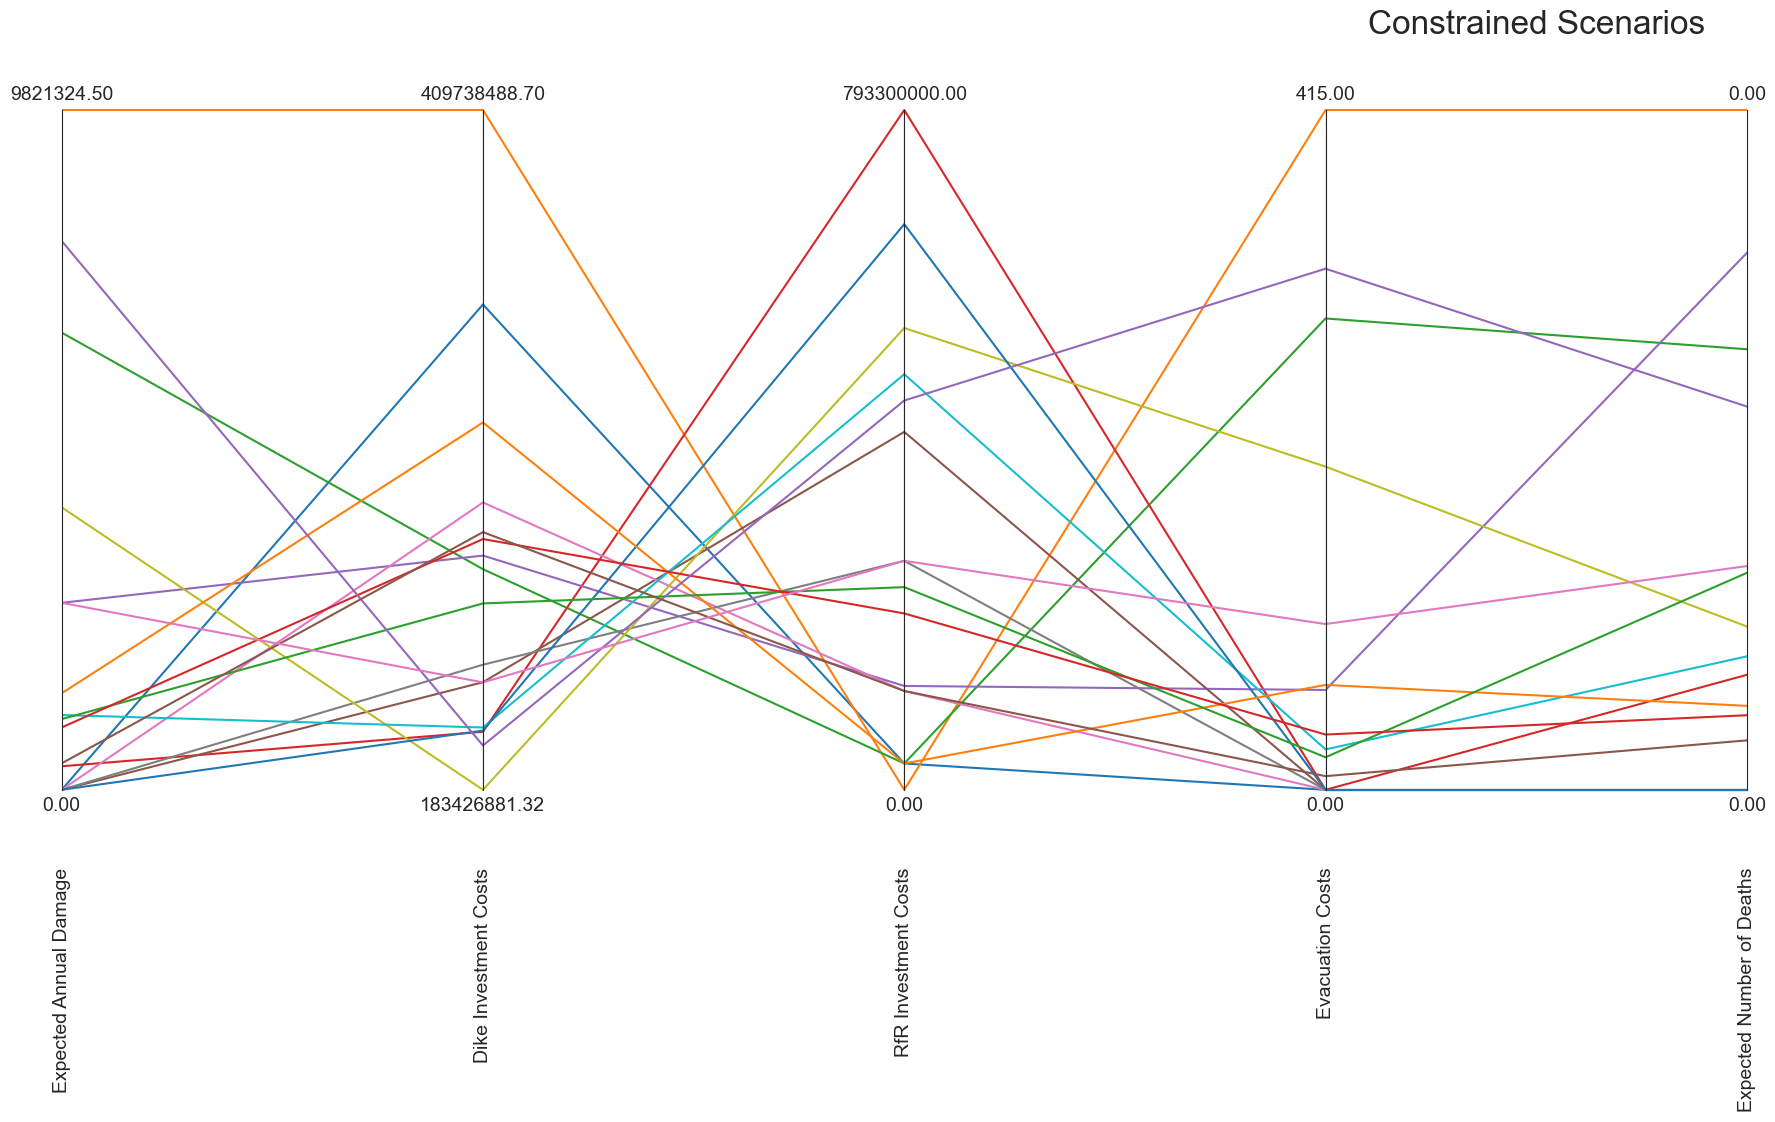

In [22]:
#plotting constrained solutions
outcomes_constrained = constrained_optim_results.loc[:, [o.name for o in dike_model.outcomes]]
outcome_limits_constrained = parcoords.get_limits(outcomes_constrained)

paraxes = parcoords.ParallelAxes(outcome_limits_constrained)
paraxes.plot(outcomes_constrained)
plt.title("Constrained Scenarios", fontsize=24)
fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()


## Uncertainty

Evaluate the  candidate solution, after constraining them,s under uncertaint againy. Performing experiments wit h????1000??????????0 scenarios for each of the selected policy options

In [23]:
# Build list of policies
policies_to_evaluate = []

for i, policy in optimization_policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
n_scenarios = 1000 # the amount of scenarios for each policy option
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 17 policies * 1 model(s) = 17000 experiments
100%|████████████████████████████████████| 17000/17000 [54:37<00:00,  5.19it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [24]:
experiments

A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                           36  135.358097      10.0   0.528075   77.007772   
1                          100  158.984741       1.5   0.731625  203.559385   
2                           25   91.127788       1.0   0.685345  348.083195   
3                           26  172.825896      10.0   0.462643  293.470968   
4                          123  105.294948       1.0   0.588427  155.986534   
...                        ...         ...       ...        ...         ...   
16995                      111   32.623570       1.5   0.354421  201.766384   
16996                       50   89.220402       1.0   0.212270  159.675926   
16997                       88  263.026065      10.0   0.786140  132.764409   
16998                       55  163.959668       1.5   0.226901  266.997200   
16999                       83   30.515726       1.0   0.803386  118.444200   

      A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0           1.5   0.473486   79.420665       1.0   0.208278  ...   
1          10.0   0.836823   33.171616       1.0   0.788803  ...   
2           1.5   0.136564   94.107572       1.5   0.088249  ...   
3           1.5   0.132847  290.300982       1.0   0.943871  ...   
4          10.0   0.582315  252.388965       1.5   0.408447  ...   
...         ...        ...         ...       ...        ...  ...   
16995       1.5   0.436969  262.582900      10.0   0.894816  ...   
16996      10.0   0.777317  161.407696       1.0   0.234068  ...   
16997       1.0   0.338266  216.941613       1.0   0.363139  ...   
16998      10.0   0.914009  267.604429       1.5   0.399399  ...   
16999       1.5   0.740335  230.918066       1.0   0.159587  ...   

       A.3_DikeIncrease 2 A.4_DikeIncrease 0  A.4_DikeIncrease 1  \
0                       3                  7                   6   
1                       3                  7                   6   
2                       3                  7                   6   
3                       3                  7                   6   
4                       3                  7                   6   
...                   ...                ...                 ...   
16995                   0                  7                   2   
16996                   0                  7                   2   
16997                   0                  7                   2   
16998                   0                  7                   2   
16999                   0                  7                   2   

       A.4_DikeIncrease 2 A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
0                       1                  9                   0   
1                       1                  9                   0   
2                       1                  9                   0   
3                       1                  9                   0   
4                       1                  9                   0   
...                   ...                ...                 ...   
16995                   0                  6                   0   
16996                   0                  6                   0   
16997                   0                  6                   0   
16998                   0                  6                   0   
16999                   0                  6                   0   

      A.5_DikeIncrease 2 scenario policy     model  
0                      7      200      3  dikesnet  
1                      7      201      3  dikesnet  
2                      7      202      3  dikesnet  
3                      7      203      3  dikesnet  
4                      7      204      3  dikesnet  
...                  ...      ...    ...       ...  
16995                  0     1195    537  dikesnet  
16996                  0     1196    537  dikesnet  
16997                  0     1197    537  dikesnet  
16998                  0     1198    537  dikesnet  
16999                  0

In [25]:
outcomes

{'Expected Annual Damage': array([0., 0., 0., ..., 0., 0., 0.]),
 'Dike Investment Costs': array([3.45004848e+08, 3.45004848e+08, 3.45004848e+08, ...,
        2.19196552e+08, 2.19196552e+08, 2.19196552e+08]),
 'RfR Investment Costs': array([3.070e+07, 3.070e+07, 3.070e+07, ..., 2.672e+08, 2.672e+08,
        2.672e+08]),
 'Evacuation Costs': array([0., 0., 0., ..., 0., 0., 0.]),
 'Expected Number of Deaths': array([0., 0., 0., ..., 0., 0., 0.])}

## Scenario Discovery 

### PRIM 
The last step of the MORDM is to conduct a scenraio discovery using PRIM as defined by Bryan & Lempert (2010). Because the policies are evaluated on a series of experiments, the constraint on deaths, considering safety and wellbeing are fundamental parts of the Delta Commission mandate, is re-applied to ensure the policies behave within the defined threshold.

Robustness measures are sensitive to the scenarios under which a policy is evaluated. Thus, by conducting the scneario discovery first, we can identify which uncertainties (or combinations of them) would lead to vulnerable system behavior. 

In [26]:
# Clean up data = policy parameters, only leaving outcomes etc.
columns_to_drop = ['A.1_DikeIncrease 0','A.1_DikeIncrease 1','A.1_DikeIncrease 2','A.2_DikeIncrease 0','A.2_DikeIncrease 1','A.2_DikeIncrease 2','A.3_DikeIncrease 0','A.3_DikeIncrease 1','A.3_DikeIncrease 2','A.4_DikeIncrease 0','A.4_DikeIncrease 1','A.4_DikeIncrease 2','A.5_DikeIncrease 0','A.5_DikeIncrease 1','A.5_DikeIncrease 2', 'policy']
columns_to_drop += ['0_RfR 0','0_RfR 1','0_RfR 2','1_RfR 0','1_RfR 1','1_RfR 2','2_RfR 0','2_RfR 1','2_RfR 2','3_RfR 0','3_RfR 1','3_RfR 2','4_RfR 0','4_RfR 1','4_RfR 2','EWS_DaysToThreat']

cleaned_experiments = experiments.copy()
cleaned_experiments.drop(columns_to_drop, axis=1, inplace=True)

In [27]:
# Apply PRIM
x = cleaned_experiments
y = outcomes['Expected Number of Deaths'] <= 0.001 # the outcome constraint to evaluate using PRIM
prim_alg = prim.Prim(x,y, threshold = 0.35, peel_alpha=0.1)
box = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 17000 points remaining, containing 12261 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.347, coverage: 0.48111899518799445, density: 1.0 restricted_dimensions: 5


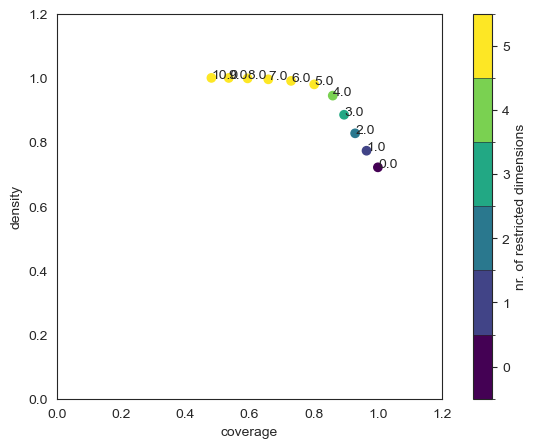

In [28]:
box.show_tradeoff(annotated=True)
fig = plt.gcf()  
fig.set_size_inches(8, 5)
plt.show()

In [29]:
point = 5 # chosen a bit randomly 
box.inspect(point)

#if save_figures:
 #   box.show_tradeoff(annotated=False)
  #  plt.savefig(figures_path + f"/prim_tradeoff.png", dpi=300)

coverage        0.801566
density         0.979860
id              5.000000
k            9828.000000
mass            0.590000
mean            0.979860
n           10030.000000
res_dim         5.000000
Name: 5, dtype: float64

              box 5                                  
                min       max       qp value qp value
A.3_pfail  0.099660  0.999745  6.197667e-197      NaN
A.1_pfail  0.100020  0.999635  8.922060e-185      NaN
A.5_pfail  0.102039  0.999163  4.272343e-164      NaN
A.2_pfail  0.098220  0.999859  1.561368e-158      NaN
A.4_pfail  0.095898  0.999900   2.913008e-69      NaN



[None]

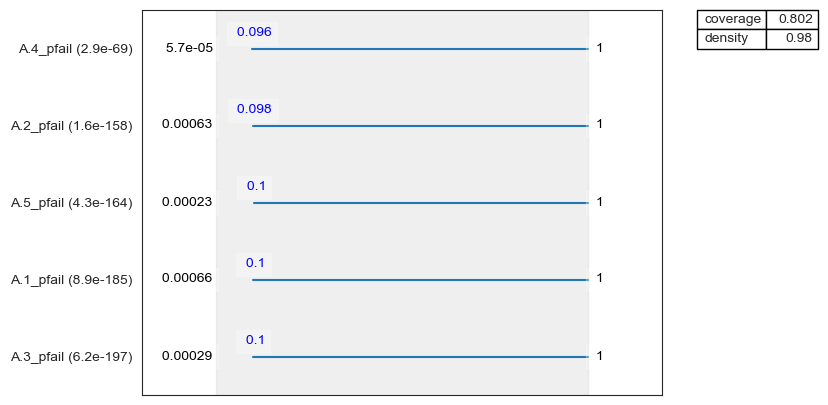

In [30]:
# Inspect PRIM results by inspecting box limits 
box.inspect(point, style='graph')
fig = plt.gcf()  
fig.set_size_inches(8, 5)  
plt.show()

#if save_figures:
 #   plt.tight_layout()
  #  plt.savefig(figures_path + f"/prim_inspect_graph.png", dpi=300)


This table shows the box limits. The darker gray background is the full range. The blue lines indicate the limits identified by PRIM for the box being inspected. The blue number indicate the limit. The number between brackets behind each parameter on the left hand side is the quasi p-value. The coverage and density are shown in the top right hand corner. 

However, as the coverage found is quite low, and in general, PRIM struggles to explain the problem without restricting a significant number of dimensions. This model illustrates that for highly non-linear models (such as this one) with many uncertain parameters, PRIM struggles to produce good results. This is largely due to PRIM trying to find orthogonal subspaces in the model input space. In case of non-linear interactions, the cases of interest are unlikely to be nicely orthogonal. Various recent journal papers have been experimenting with other rule induction algorithms that make less restrictive assumptions. However, this often comes at the expense of interpretatiblity.

In [31]:
box.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9
C:\Users\lykao\New folder\Lib\site-packages\ema_workbench\analysis\prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '13.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value


reproduce coverage  reproduce density
A.1_pfail                             100.0              100.0
A.2_pfail                             100.0              100.0
A.3_pfail                             100.0              100.0
A.4_pfail                             100.0              100.0
A.5_pfail                             100.0              100.0
A.0_ID flood wave shape                 0.0                0.0
A.1_Bmax                                0.0                0.0
A.1_Brate                               0.0                0.0
A.2_Bmax                                0.0                0.0
A.2_Brate                               0.0                0.0
A.3_Bmax                                0.0                0.0
A.3_Brate                               0.0                0.0
A.4_Bmax                                0.0                0.0
A.4_Brate                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_Brate                               0.0                0.0
discount rate 0                         0.0                0.0
discount rate 1                         0.0                0.0
discount rate 2                         0.0                0.0

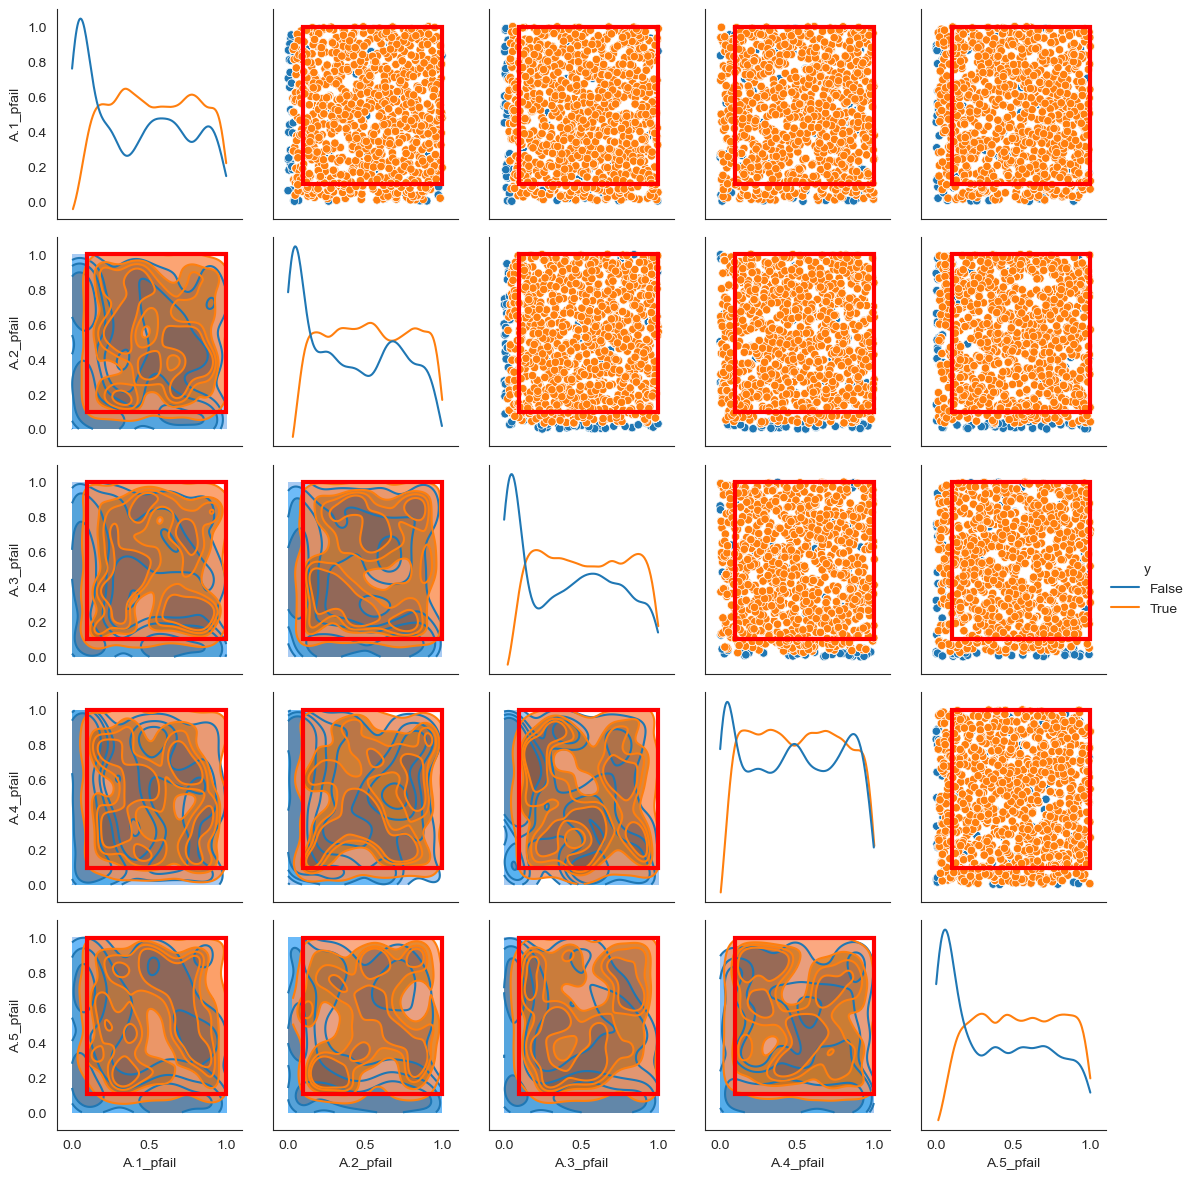

In [32]:
box.select(5)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

The above pair-wise scatterplot shows in orange the cases of interest and in blue the cases not of interest. The diagonal shows the Guassian kernel density estimate for both. The red square indicates the identified box limits for each pair of parameters. This plot offers a useful diagnostic of the identified box limits.

## Robustness

The final step of our MORDM optimisation process is the evaluation of robustness. Now have a large number of candidate solutions/policies, the robustness analysis much more targeted and policy-relevant. hat we can re-evaluate over the various deeply uncertain factors to assess their robustness against uncertainties.

Here, we decide to use two complimentary robustenss metrics: Signal-to-noise ratio and Maximum Regret

These two work well together as, due to delta's mandate, different outcomes require different robustness considerations allowed.

### Signal to Noise Ratio

The signal-to-noise ratio assesses how consistently a policy performs relative to variability. Given that the Delta Commissioner’s mandate prioritizes minimizing deaths, costs, and damages, a low signal-to-noise ratio is preferred. This metric is especially relevant for outcomes, exactly like our outcome "expected number of deaths" where there is a strict threshold to meet and almost NO tolerance for deviation.

In [33]:
#setting up function for signal to noise 
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
overall_scores = {}


In [34]:
# Loop over policies
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy'] == policy

    for outcome in dike_model.outcomes:
        value = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores

scores = pd.DataFrame.from_dict(overall_scores).T
scores


Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
12             5.700885e+15           4.097385e+08                   0.0   
126            1.515348e+16           1.306834e+01           417700000.0   
135            1.002602e+16           3.326916e+01           115300000.0   
18             5.517234e+15           2.568762e+08            30700000.0   
244            2.806899e+16           1.341560e+01           267200000.0   
275            1.573534e+16           5.466547e+00           538900000.0   
3              3.434261e+16           6.169167e+01            30700000.0   
317            4.059178e+16           6.084668e+00           485000000.0   
38             1.825359e+16           2.027506e+08           793300000.0   
397            1.453397e+16           6.054163e+00           660100000.0   
416            4.387903e+15           1.822228e+01            30700000.0   
434            2.989950e+16           1.463117e+01           236500000.0   
446            9.525603e+14           2.386256e+01           205800000.0   
463            4.422661e+16           1.981658e+08           454300000.0   
488            2.908691e+16           2.692035e+08           115300000.0   
52             1.417220e+16           2.614009e+08           121200000.0   
537            1.042349e+16           1.306513e+01           267200000.0   

     Evacuation Costs  Expected Number of Deaths  
12       4.273002e+06                   0.000059  
126      0.000000e+00                   0.007949  
135      0.000000e+00                   0.005054  
18       4.315494e+06                   0.000076  
244      3.334828e+06                   0.000291  
275      5.080093e+06                   0.000127  
3        0.000000e+00                   0.017520  
317      1.784705e+06                   0.002247  
38       0.000000e+00                   0.009102  
397      8.738570e+05                   0.000894  
416      2.403122e+06                   0.000043  
434      1.599955e+06                   0.001832  
446      1.655714e+06                   0.000045  
463      7.314243e+06                   0.000473  
488      1.448113e+06                   0.001775  
52       1.156203e+06                   0.001091  
537      2.037698e+06                   0.000111

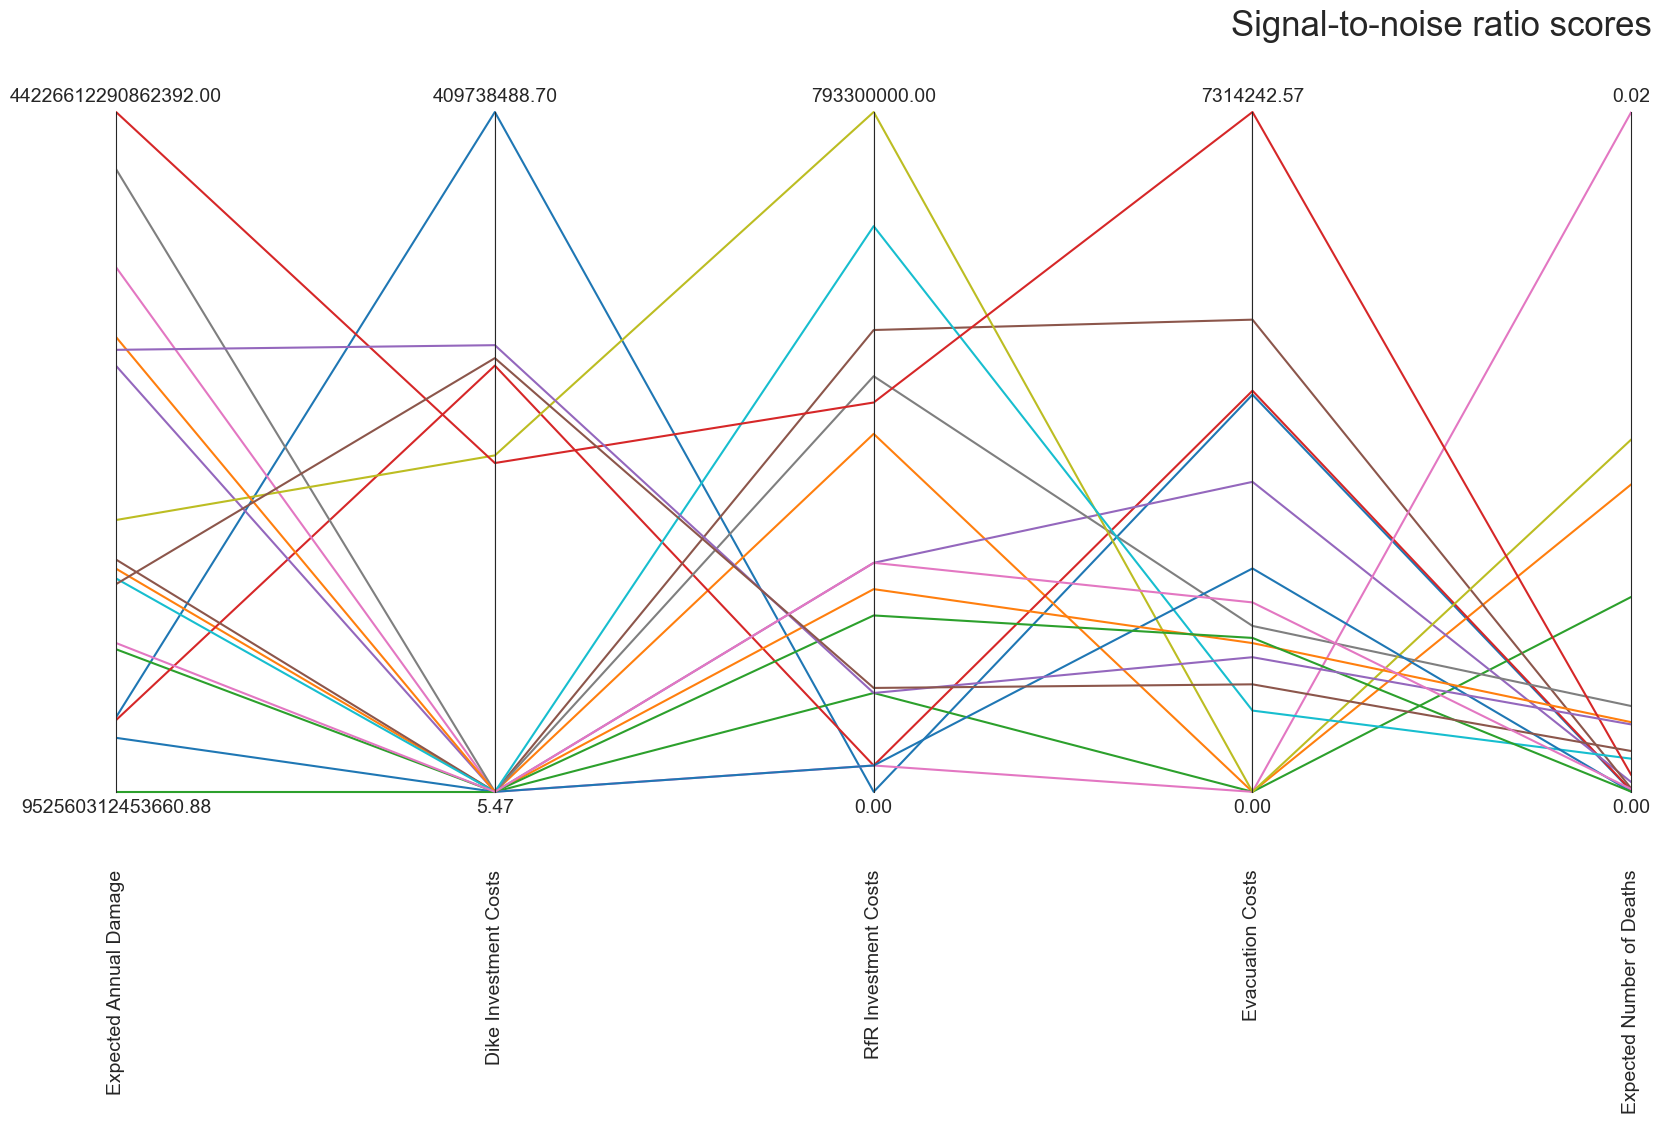

In [35]:
#Plot the pool of scores
score_data = scores
score_limits = parcoords.get_limits(score_data)

# Save data
#if save_result_data:
 #   scores.to_csv(results_path + "/sn_scores.csv")

paraxes = parcoords.ParallelAxes(score_limits)
paraxes.plot(score_data)
plt.title("Signal-to-noise ratio scores", fontsize=25)
#if save_figures:
 #   plt.savefig(figures_path + f"/parcoords_sn.png", dpi=300)


fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()



# Maximum Regret

Maximum regret measures how far a policy’s outcome falls short of the best possible outcome in a given scenario. We aim for lowest maximum regret in all the outcomes.


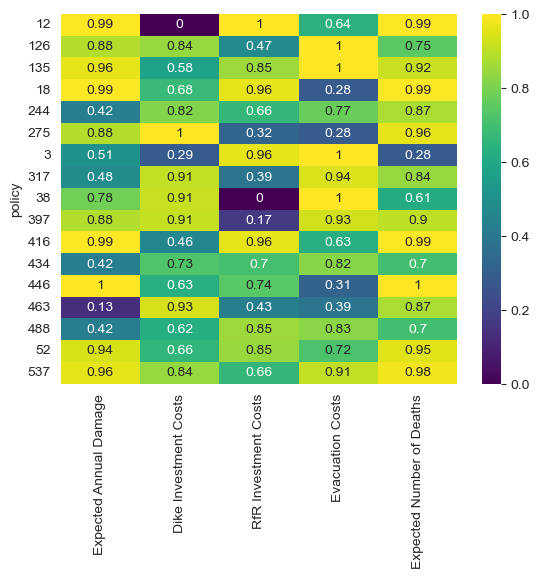

In [36]:
#Calculate Miximum Regret 
def calculate_regret(data, best):
    return np.abs(best-data)


overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    #Create a DataFrame with all the relevant information
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name],
        "policy": experiments['policy'],
        "scenario": experiments['scenario']
    })

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

#Create heatmap
max_regret_df = pd.DataFrame(max_regret)
plt.figure()
sns.heatmap(max_regret_df/max_regret_df.max(), cmap='viridis', annot=True)
#if save_figures:
 #   plt.savefig(figures_path + f"/maxregret_heatmap.png", dpi=300)
plt.show()


In [37]:
len(outcome_regret)

1000

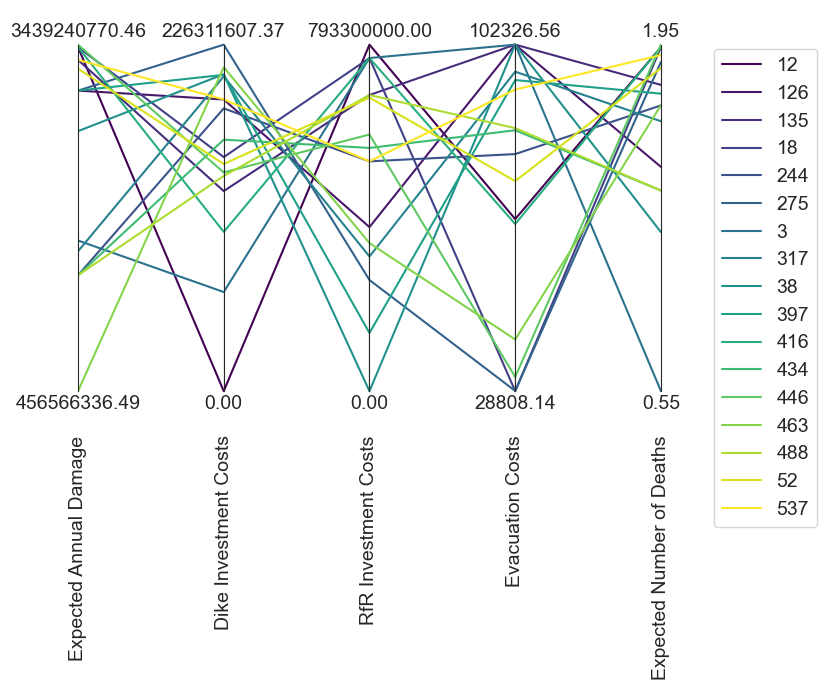

In [38]:

data = max_regret_df
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)

colour_map = matplotlib.colormaps['viridis']
n = data.shape[0]

for i, (index, row) in enumerate(data.iterrows()):
    color = colour_map(i / (n - 1))  # normalized index for colormap
    paraxes.plot(row.to_frame().T, label=str(index), color=color)

fig = plt.gcf()
fig.set_size_inches(7, 7)

paraxes.legend()
plt.show()
#if save_figures:
 #   plt.savefig(figures_path + f"/maxregret_parcoords.png", dpi=300)


In [39]:
policy_regret = collections.defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]


In [40]:
# Number of policies to plot
n_policies = len(policy_regret) # 19 policies 
n_policies

17

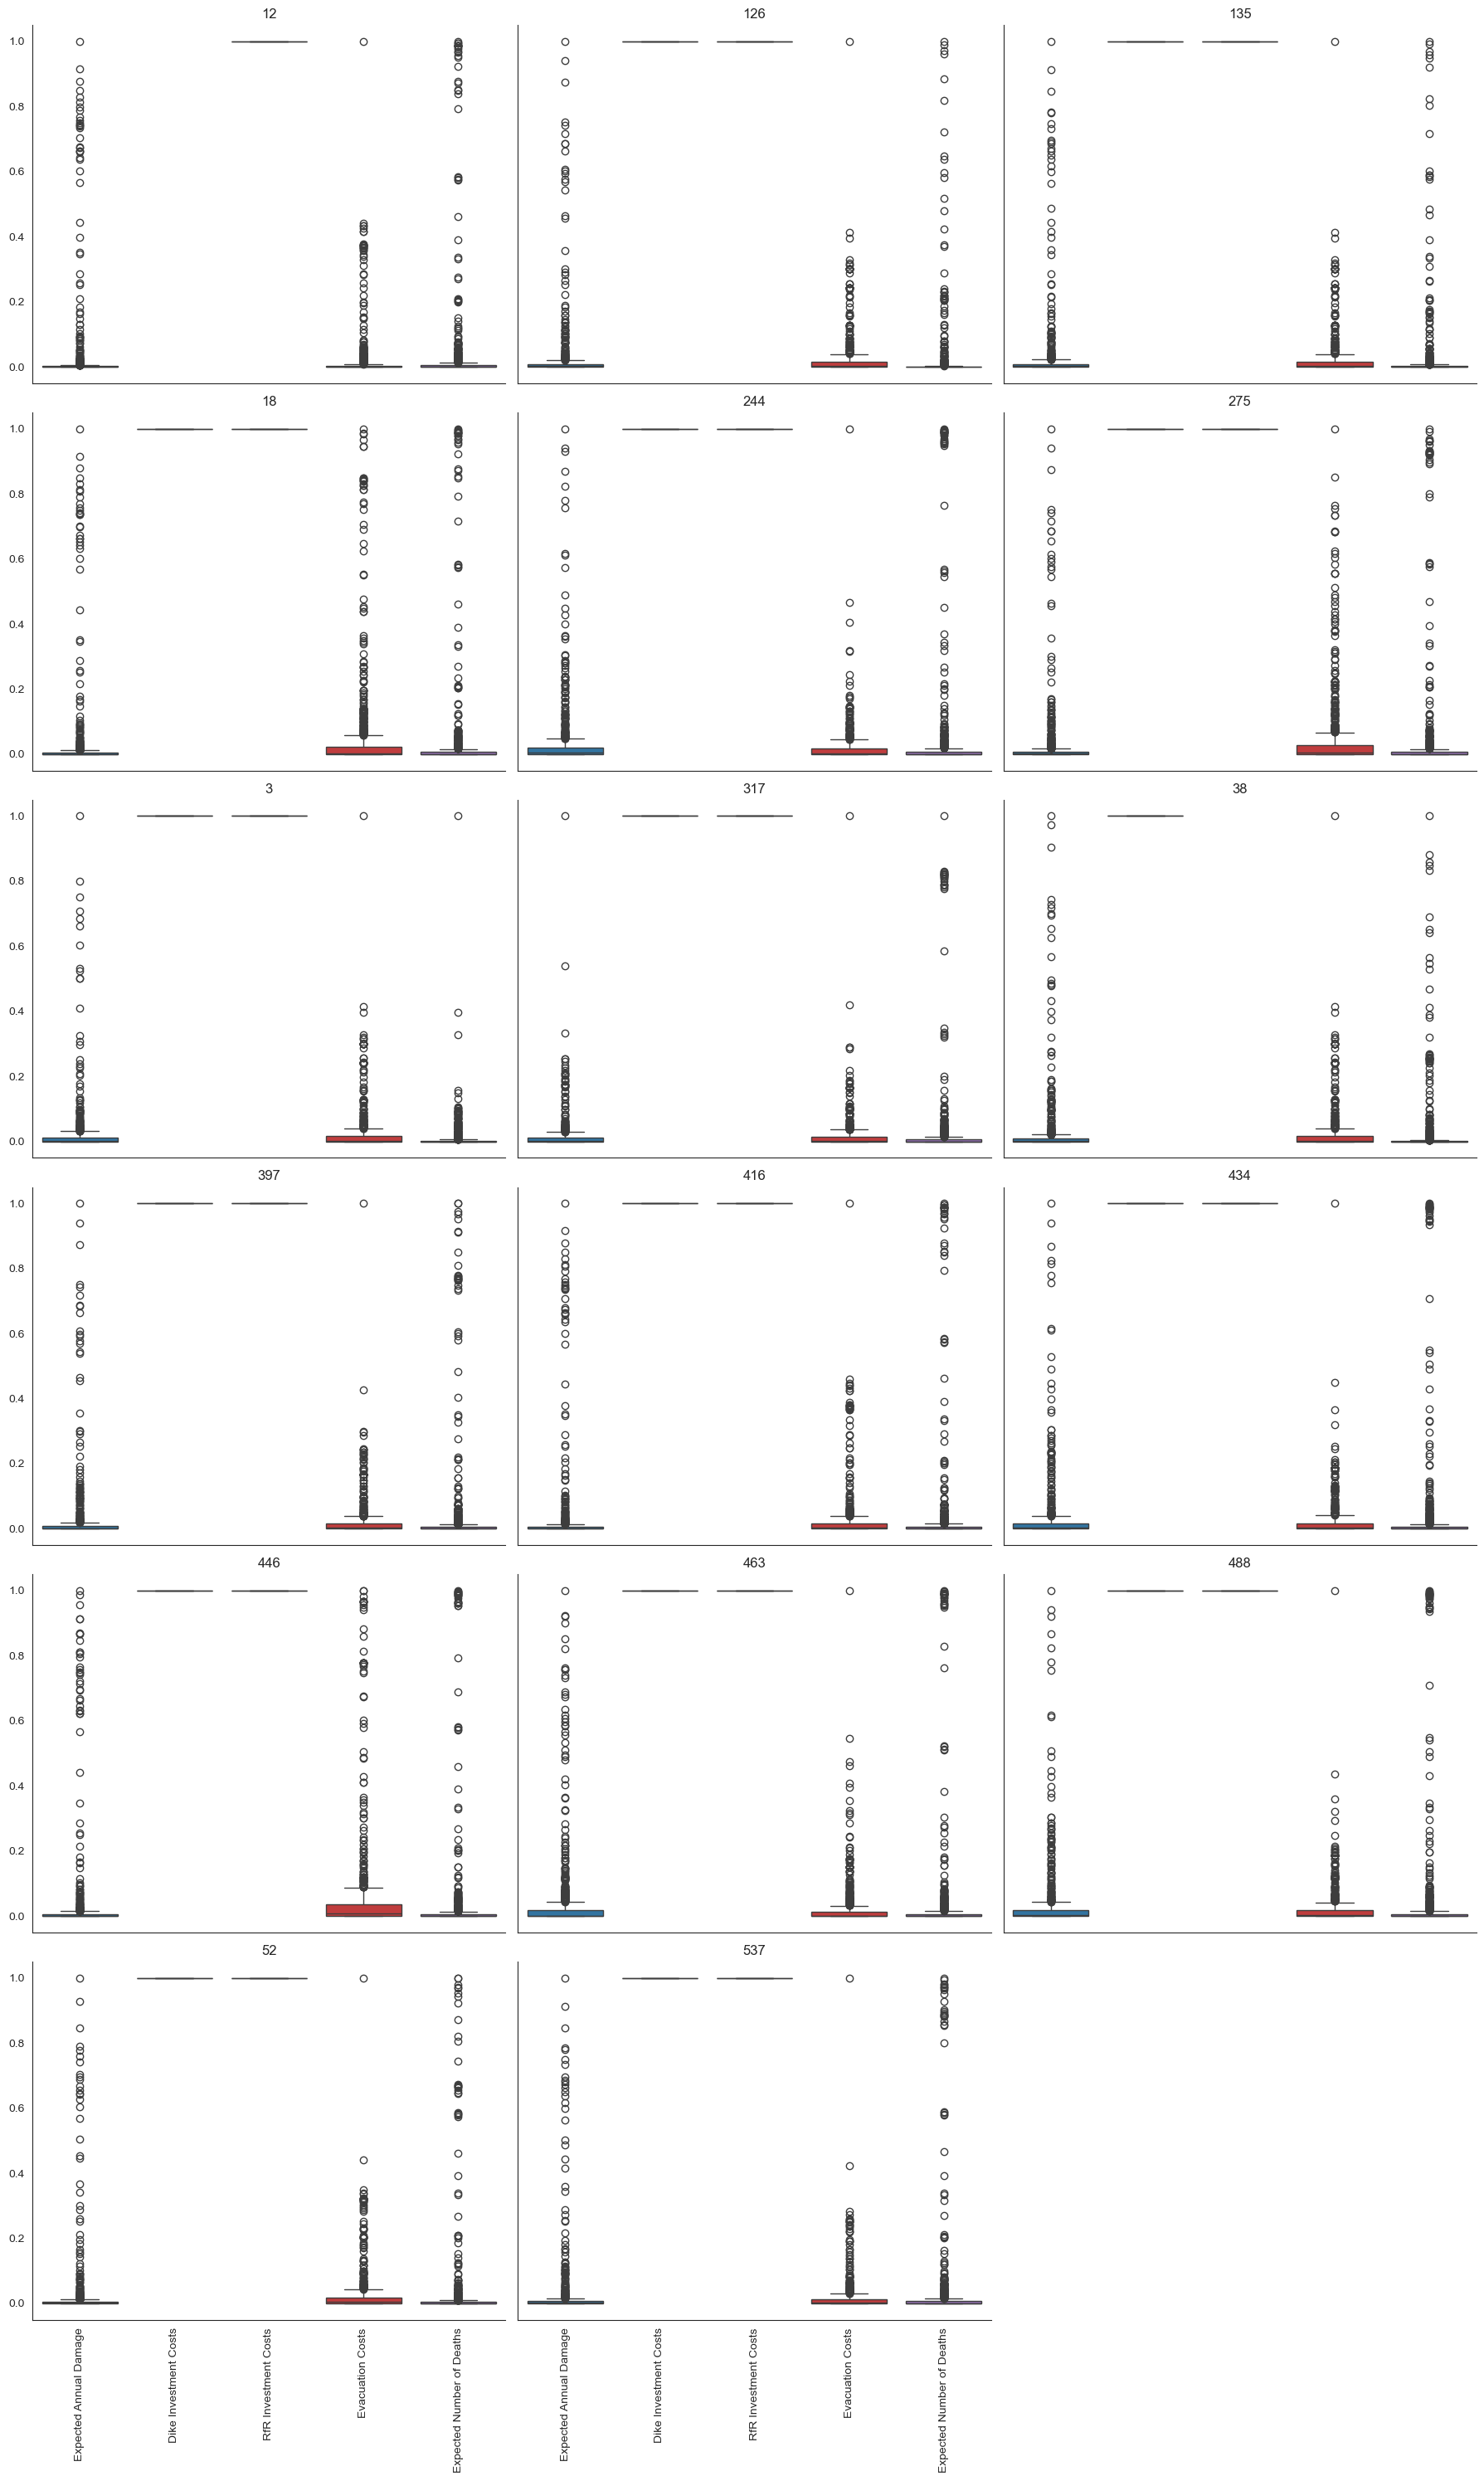

In [41]:
#making sure visualisation works and doesn't overlap
ncols = 3
nrows = math.ceil(n_policies / ncols)

#plot 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*5), sharey=True, sharex=True)
axes = axes.flatten()  # Flatten in case axes is 2D

for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)
    
    # Normalize data for fair visual comparison
    data = data / data.max(axis=0)
    
    sns.boxplot(data=data, ax=ax)
    sns.despine(ax=ax)
    ax.set_title(str(policy))
    ax.tick_params(axis='x', labelrotation=90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
